In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import hdbscan        #install hdbscan

In [2]:
df = pd.read_csv('../data/train_preprocessed.csv', encoding='utf-8')

# Examine the data
df.head()

,offres_recues_pipeline__offresRecues,other_num_pipeline__montant,other_num_pipeline__dureeMois,other_num_pipeline__origineFrance,binary_pipeline__marcheInnovant,binary_pipeline__sousTraitanceDeclaree,binary_pipeline__idAccordCadre,cat_pipeline__nature_Marché,cat_pipeline__nature_Marché de défense ou de sécurité,cat_pipeline__nature_Marché de partenariat,...,cat_pipeline__codeCPV_2_80000000,cat_pipeline__codeCPV_2_85000000,cat_pipeline__codeCPV_2_90000000,cat_pipeline__codeCPV_2_92000000,cat_pipeline__codeCPV_2_98000000,cat_pipeline__tauxAvance_cat_large_advance,cat_pipeline__tauxAvance_cat_medium_advance,cat_pipeline__tauxAvance_cat_missing,cat_pipeline__tauxAvance_cat_no_advance,cat_pipeline__tauxAvance_cat_small_advance
0,-0.578746,-0.511996,0.153094,-0.088438,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.032831,2.356890,0.616194,-0.088438,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.578746,1.642289,-0.502836,-0.088438,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.032831,1.704263,0.916718,-0.088438,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.032831,1.664240,0.616194,-0.088438,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [3]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.9)  # Keep enough components to explain 90% of variance
df_pca = pca.fit_transform(df)

print(f"Original dimensions: {df.shape[1]}")
print(f"Reduced dimensions: {df_pca.shape[1]}")
print(f"Explained variance: {sum(pca.explained_variance_ratio_):.2f}")

Original dimensions: 74
Reduced dimensions: 15
Explained variance: 0.90


In [ ]:
# HDBSCAN hyperparameter exploration

# Define a range of min_cluster_size values to test
min_cluster_sizes = [5, 10, 15, 20, 50, 100]
min_samples = 5  # Similar to DBSCAN's min_samples

results = []

for min_cluster_size in min_cluster_sizes:
    # Apply HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean',
        gen_min_span_tree=True,
        cluster_selection_method='eom'  # 'eom' is usually better for variable density
    )

    clusterer.fit(df_pca)
    labels = clusterer.labels_

    # Calculate metrics
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    noise_ratio = 100 * n_noise / len(df_pca)

    results.append({
        'min_cluster_size': min_cluster_size,
        'num_clusters': n_clusters,
        'noise_points': n_noise,
        'noise_percentage': noise_ratio
    })

    print(f"min_cluster_size = {min_cluster_size}:")
    print(f"  Number of clusters: {n_clusters}")
    print(f"  Number of noise points: {n_noise}")
    print(f"  Percentage of noise: {noise_ratio:.2f}%")

    # Calculate silhouette score if more than one cluster and not all noise
    if n_clusters > 1 and n_noise < len(df_pca):
        # Filter out noise points
        mask = labels != -1
        silhouette_avg = silhouette_score(df_pca[mask], labels[mask])
        print(f"  Silhouette Score: {silhouette_avg:.3f}")
    print()

# Display results table
results_df = pd.DataFrame(results)
results_df

/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size = 5:
  Number of clusters: 10404
  Number of noise points: 87316
  Percentage of noise: 38.35%
  Silhouette Score: 0.422



/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size = 10:
  Number of clusters: 4878
  Number of noise points: 81063
  Percentage of noise: 35.61%
  Silhouette Score: 0.221



/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size = 15:
  Number of clusters: 2874
  Number of noise points: 75159
  Percentage of noise: 33.01%
  Silhouette Score: 0.109



/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size = 20:
  Number of clusters: 2172
  Number of noise points: 73008
  Percentage of noise: 32.07%
  Silhouette Score: 0.077



/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size = 50:
  Number of clusters: 981
  Number of noise points: 61161
  Percentage of noise: 26.86%
  Silhouette Score: 0.021



/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size = 100:
  Number of clusters: 507
  Number of noise points: 52875
  Percentage of noise: 23.23%
  Silhouette Score: 0.031



,min_cluster_size,num_clusters,noise_points,noise_percentage
0,5,10404,87316,38.353180
1,10,4878,81063,35.606576
2,15,2874,75159,33.013270
3,20,2172,73008,32.068452
4,50,981,61161,26.864708
5,100,507,52875,23.225118


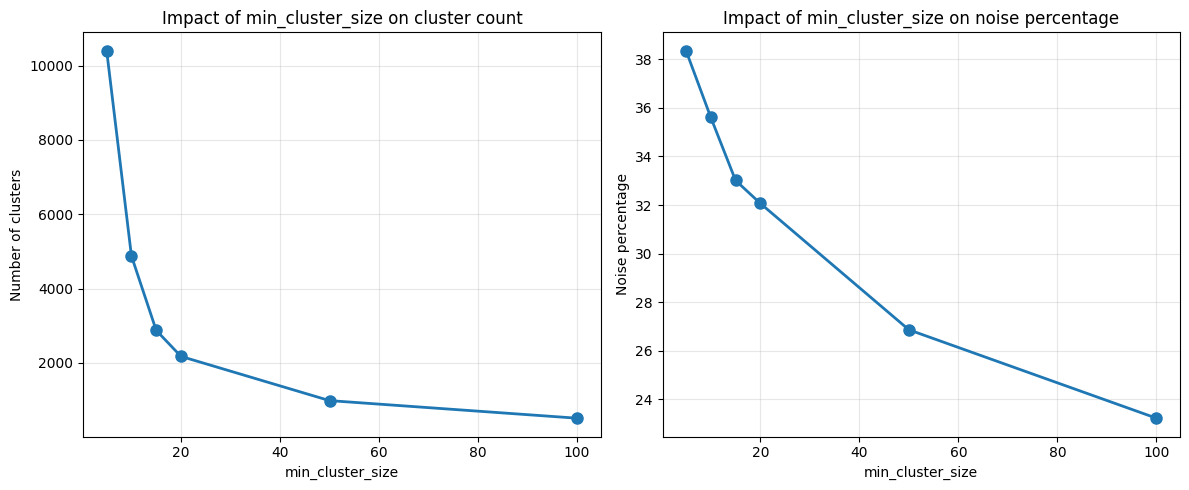

In [5]:
# Visualize HDBSCAN parameter impact on clusters and noise
plt.figure(figsize=(12, 5))

# Plot number of clusters
plt.subplot(1, 2, 1)
plt.plot(results_df['min_cluster_size'], results_df['num_clusters'], 'o-', linewidth=2, markersize=8)
plt.xlabel('min_cluster_size')
plt.ylabel('Number of clusters')
plt.title('Impact of min_cluster_size on cluster count')
plt.grid(True, alpha=0.3)

# Plot percentage of noise points
plt.subplot(1, 2, 2)
plt.plot(results_df['min_cluster_size'], results_df['noise_percentage'], 'o-', linewidth=2, markersize=8)
plt.xlabel('min_cluster_size')
plt.ylabel('Noise percentage')
plt.title('Impact of min_cluster_size on noise percentage')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
best_min_cluster_size = 20  # Updated based on analysis

# Apply HDBSCAN with selected parameters
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=best_min_cluster_size,
    min_samples=min_samples,
    metric='euclidean',
    cluster_selection_method='eom'
)

# Fit and add labels to dataframe
clusterer.fit(df_pca)
df['cluster'] = clusterer.labels_

# Analyze clusters
n_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)
n_noise = list(df['cluster']).count(-1)

print(f"HDBSCAN Results with min_cluster_size={best_min_cluster_size}, min_samples={min_samples}:")
print(f"Number of clusters: {n_clusters}")
print(f"Noise points: {n_noise} ({100 * n_noise / len(df):.2f}%)")


/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN Results with min_cluster_size=20, min_samples=5:
Number of clusters: 2173
Noise points: 73008 (32.07%)


/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/loicdogon/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/loicdogon/.pyenv/versions/3.1

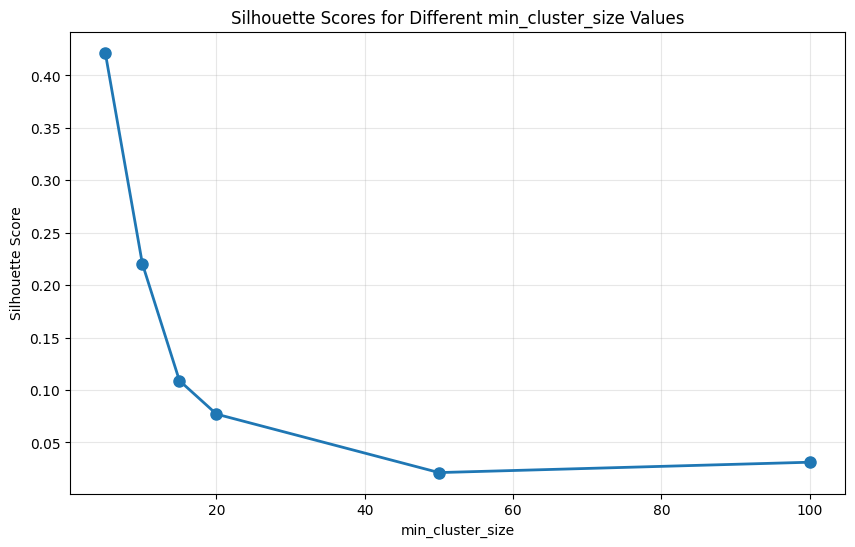

In [ ]:
# Add a plot showing silhouette scores for different min_cluster_sizes
silhouette_scores = []

for min_cluster_size in min_cluster_sizes:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean',
        gen_min_span_tree=True,
        cluster_selection_method='eom'
    )

    clusterer.fit(df_pca)
    labels = clusterer.labels_

    # Calculate silhouette score if more than one cluster and not all noise
    if len(set(labels)) > 1 and list(labels).count(-1) < len(df_pca):
        mask = labels != -1
        silhouette_avg = silhouette_score(df_pca[mask], labels[mask])
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(0)


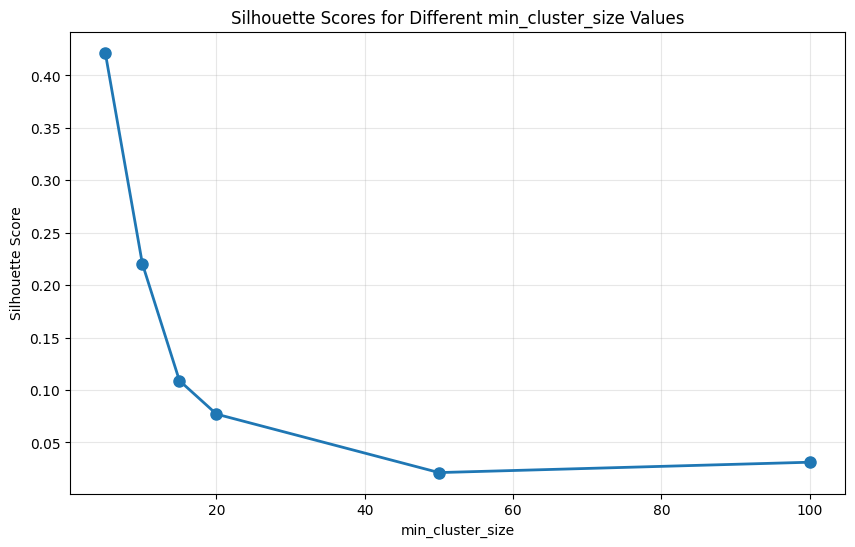

In [8]:

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(min_cluster_sizes, silhouette_scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('min_cluster_size')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different min_cluster_size Values')
plt.grid(True, alpha=0.3)
plt.show()

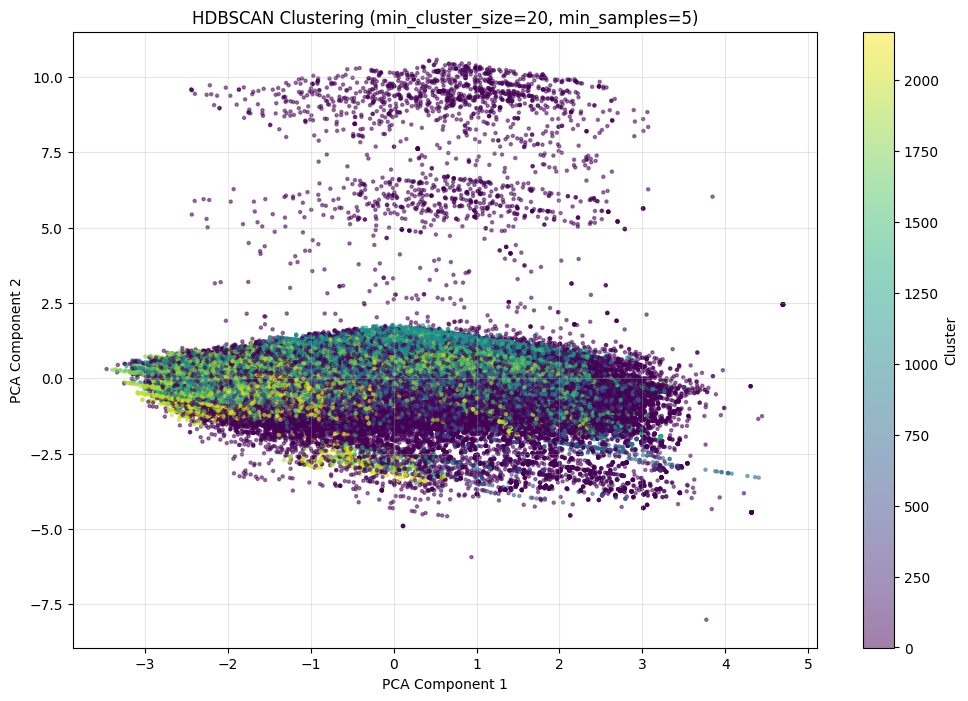

In [9]:
# 2D visualization using PCA
# For visualization, use the first 2 PCA components
vis_pca = PCA(n_components=2).fit_transform(df.drop('cluster', axis=1))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(vis_pca[:, 0], vis_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.5, s=5)
plt.colorbar(scatter, label='Cluster')
plt.title(f'HDBSCAN Clustering (min_cluster_size={best_min_cluster_size}, min_samples={min_samples})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True, alpha=0.3)
plt.show()